In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# ls -l /gdrive/My\ Drive/colab/Bangali.AI/data

## 2-1 Image Visualization and folding

### 필요 Package Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
IS_COLAB = False

if IS_COLAB:
  path = "/gdrive/My Drive/colab/Bangali.AI/data/"

  parquet_list = []

  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          if ".parquet" in filename:
              parquet_list.append(filename)

  train_file_index = [True if "train" in element else False for element in parquet_list]
  test_file_index = list(map(lambda x: False if x==True else True ,train_file_index))

  parquet_np_list = np.array(parquet_list)

  sorted_train_list = np.sort(parquet_np_list[train_file_index])
  sorted_test_list = np.sort(parquet_np_list[test_file_index])

  dict_train = dict()

  for idx,element in enumerate(sorted_train_list):
      full_path = path+element
      parquet = pd.read_parquet(full_path)
      dict_train[f"parquet_{idx}"] = parquet
      break

  train0 = dict_train["parquet_0"]
  # wo_id = train0.columns.values[1:]
  # train0 = train0[wo_id] 

else:
    path = "/kaggle/input/bengaliai-cv19/"
    parquet_list = []

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if ".parquet" in filename:
                parquet_list.append(filename)

    train_file_index = [True if "train" in element else False for element in parquet_list]
    test_file_index = list(map(lambda x: False if x==True else True ,train_file_index))

    parquet_np_list = np.array(parquet_list)

    sorted_train_list = np.sort(parquet_np_list[train_file_index])

    dict_train = dict()

    for idx,element in enumerate(sorted_train_list):
        full_path = path+element
        parquet = pd.read_parquet(full_path)
        dict_train[idx] = parquet
        break

    train0 = dict_train[0]
    wo_id = train0.columns.values[1:]
#     train0 = train0[wo_id] 

하나의 parquet내에는 50210장의 이미지가 있으며, 해당 이미지는 137x236의 grey scale된 데이터가 있기 때문에 32330 개의 컬럼이 있는 것이다.

In [11]:
parquet0 = train0.copy()

In [12]:
image_id = train0["image_id"]
train0 = train0[train0.columns[1:]]

사진과 같은 픽셀 값은 무조건 0~255의 값을 가지기 때문에 더 큰 데이터타입을 요할 필요가 없으므로 unit8로 데이터타입을 변경한다. (하지만... 이미 되어있음)

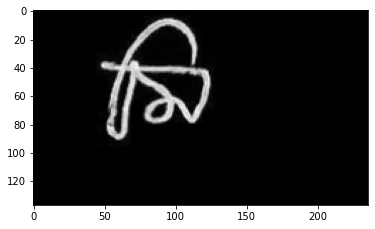

In [19]:
random_value = np.random.randint(50210)
train_sample = train0.loc[random_value,:]

train_sample = train_sample.values.reshape(137,236)

plt.imshow(255-train_sample,cmap='gray')

위의 random한 결과값들을 보면서, 개별 캐릭터가 어디 치우쳐져 있지 않는지 확인할 것. 그리고 Augmentation을 할 때도 특정 일부 샘플을 참고해서 추출하지 말고 전체 형태를 모두 본 다음에 실시할 것

## 2-2 Multi-label Stratification Folding

In [20]:
df_train = pd.read_csv(path+"train.csv")
df_train

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


Text(0.5, 0.95, "Label's count distribution in train dataset")

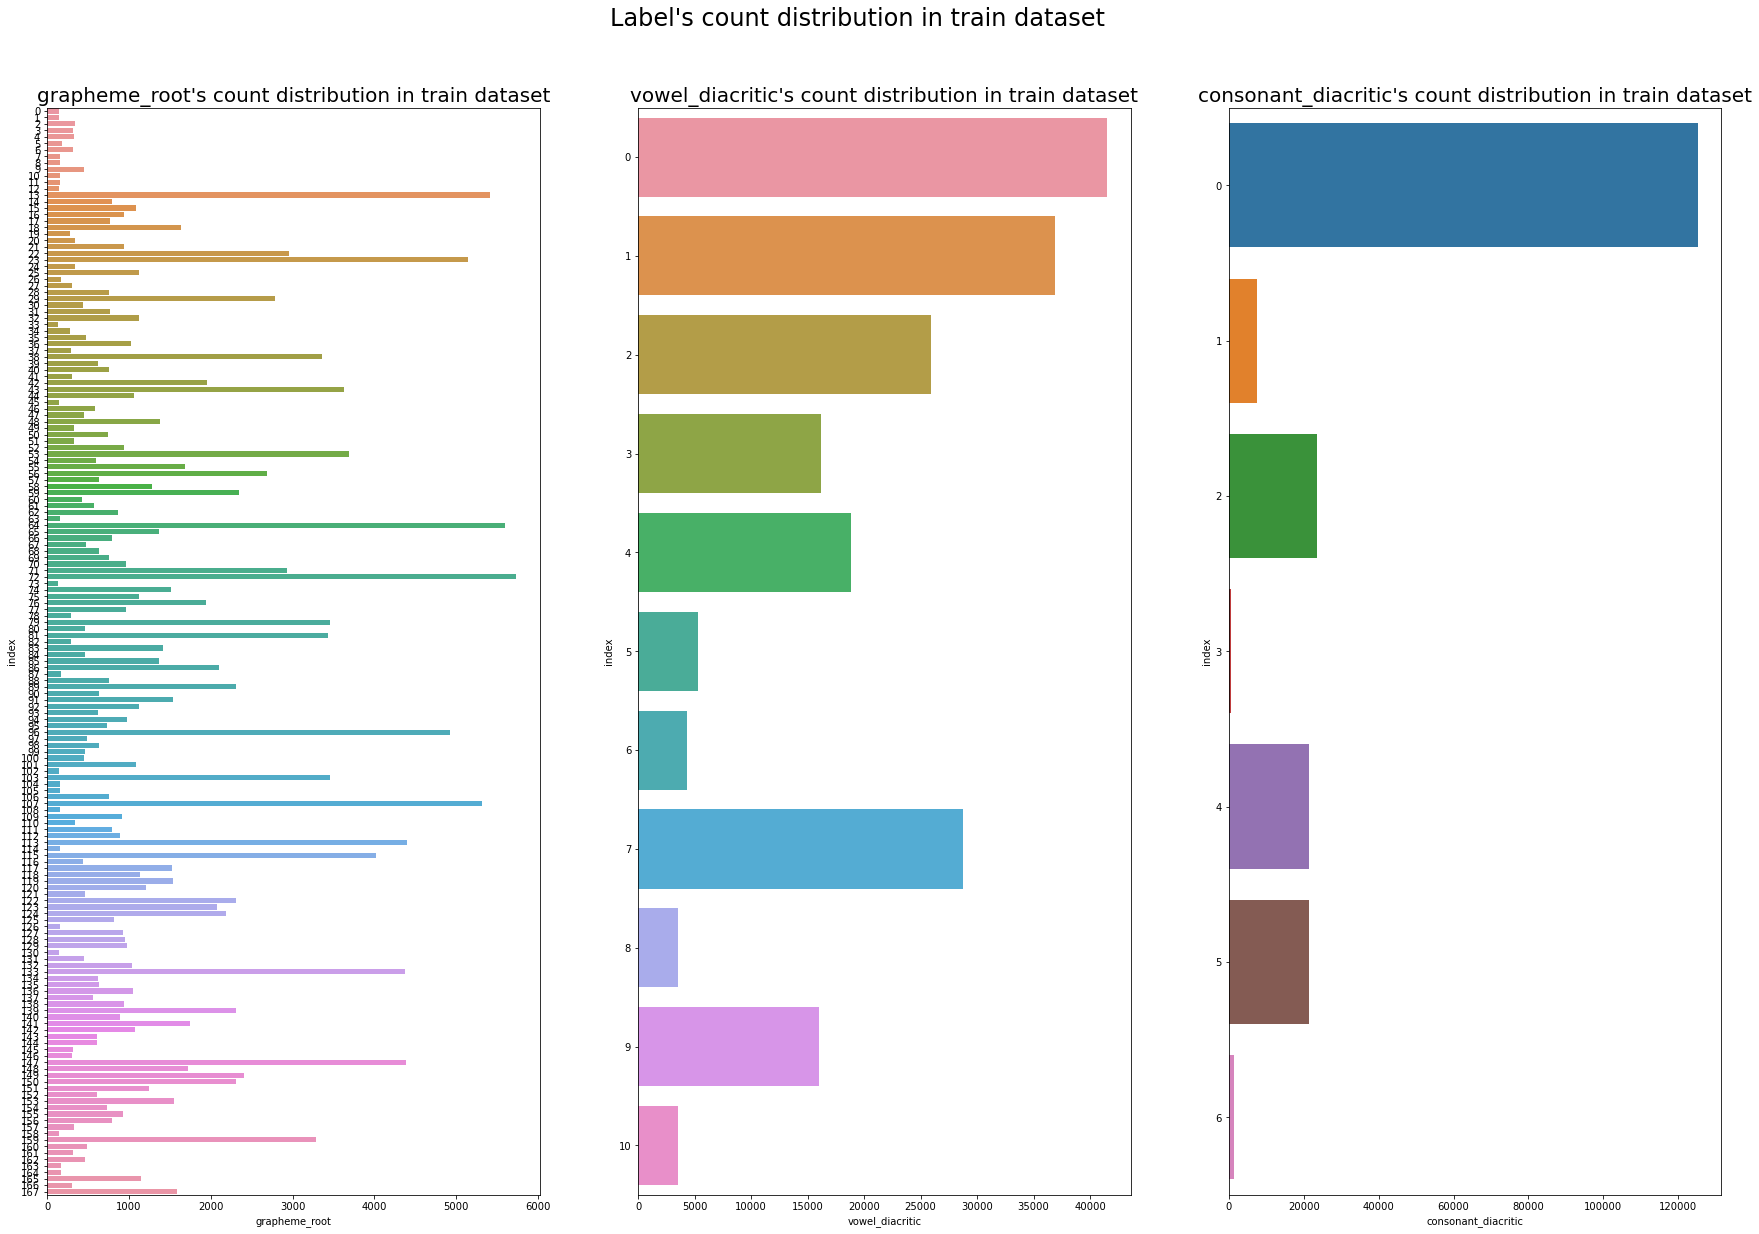

In [21]:
fig, axes = plt.subplots(figsize=[30,20],nrows=1,ncols=3)

target_cols = df_train.columns[1:4]

for idx, ax in enumerate(axes):

  column = target_cols[idx]
  dummy = df_train[column].value_counts().reset_index()
  sns.barplot(data=dummy,x=column,y="index",orient='h',ax=ax)

  ax.set_title(f"{column}'s count distribution in train dataset",fontsize=20)

plt.suptitle("Label's count distribution in train dataset",y=0.95,fontsize=24)

이미지처리 또한 마찬가지로 학습시에 편향되지 않도록 학습시 Label의 분포를 전체분포를 반영하는 방식으로 Stratified하게 추출해야 한다. 하지만, 여기서는 Multi-label을 Stratified하게 처리해야 한다.

* Sklearn 에는 이미 Staritified K Fold 방식이 있지만 이는 Single Lable에 대해서만 적용가능

하지만, Multi Label의 처리를 위한 패키지가 존재한다. 

<a href="https://github.com/trent-b/iterative-stratification">**iterative-stratification** </a>


In [22]:
!pip install iterative-stratification

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


image_id 전처리

In [23]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

df_train_X = df_train["image_id"]
df_train_y = df_train[df_train.columns[1:4]]

multi_kfold = MultilabelStratifiedKFold(n_splits=5,random_state=0)

for idx,(train_idx,valid_idx) in enumerate(multi_kfold.split(df_train_X,df_train_y)):
  df_train.loc[valid_idx,"fold"] = int(idx)

df_train["image_id"] = df_train["image_id"].apply(lambda x:int(x.split("_")[1]))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=False, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [24]:
df_train

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,fold
0,0,15,9,5,ক্ট্রো,4.0
1,1,159,0,0,হ,1.0
2,2,22,3,5,খ্রী,3.0
3,3,53,2,2,র্টি,1.0
4,4,71,9,5,থ্রো,0.0
...,...,...,...,...,...,...
200835,200835,22,7,2,র্খে,2.0
200836,200836,65,9,0,ত্তো,4.0
200837,200837,2,1,4,অ্যা,1.0
200838,200838,152,9,0,স্নো,1.0


In [ ]:
# df_train.to_csv(path+"fold/parquet0_fold5.csv",index=False)

## 2.3 Efficient Learning Prcoess

해당 대회는 .parquet 파일로 되어있는 데이터를 판다스로 읽어서 진행하는 대회이다. 워낙 파일이 크다보니 메모리가 모자라서 Kernal이 죽어버리는 경우도 있으며, 판다스 자체는 읽고 쓰는 속도가 느리다. 그리하여 학습을 진행하는 시간이 오래걸리게 된다. 

어떻게 이런 현상을 해소할 수 있을까??

In [ ]:
import joblib
from tqdm import tqdm

In [25]:
parquet_list = []

for dirname, _, filenames in os.walk(path):
  for filename in filenames:
      if ".parquet" in filename:
          parquet_list.append(filename)

train_file_index = [True if "train" in element else False for element in parquet_list]
test_file_index = list(map(lambda x: False if x==True else True ,train_file_index))

parquet_np_list = np.array(parquet_list)

sorted_train_list = np.sort(parquet_np_list[train_file_index])
sorted_test_list = np.sort(parquet_np_list[test_file_index])

dict_train_path = dict()
dict_test_path = dict()

for idx,element in enumerate(sorted_train_list):
  full_path = path+element
  dict_train_path[f"parquet_{idx}"] = full_path

for idx,element in enumerate(sorted_test_list):
  full_path = path+element
  dict_test_path[f"parquet_{idx}"] = full_path

In [26]:
dict_train_path

{'parquet_0': '/kaggle/input/bengaliai-cv19/train_image_data_0.parquet',
 'parquet_1': '/kaggle/input/bengaliai-cv19/train_image_data_1.parquet',
 'parquet_2': '/kaggle/input/bengaliai-cv19/train_image_data_2.parquet',
 'parquet_3': '/kaggle/input/bengaliai-cv19/train_image_data_3.parquet'}

하나의 .parquet은 약 5만개의 row. 즉, 5만개의 이미지가 있는데, 이를 pytorch를 활용하여 하나의 이미지씩 읽어서, 새로운 데이터셋으로 생성함

pkl로 dump하고 load하면 좋겠지만, 따로 save하는데 별도 시간이 들어서 numpy array로 하여 진행하자.

In [31]:
image_id

0            Train_0
1            Train_1
2            Train_2
3            Train_3
4            Train_4
            ...     
50205    Train_50205
50206    Train_50206
50207    Train_50207
50208    Train_50208
50209    Train_50209
Name: image_id, Length: 50210, dtype: object

In [30]:
train0

,0,1,2,3,4,5,6,7,8,9,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,254,253,252,253,251,252,253,251,251,253,...,253,253,253,253,253,253,253,253,253,251
1,251,244,238,245,248,246,246,247,251,252,...,255,255,255,255,255,255,255,255,255,254
2,251,250,249,250,249,245,247,252,252,252,...,254,253,252,252,253,253,253,253,251,249
3,247,247,249,253,253,252,251,251,250,250,...,254,254,254,254,254,253,253,252,251,252
4,249,248,246,246,248,244,242,242,229,225,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,247,250,250,250,252,250,250,250,251,250,...,246,248,252,252,249,248,250,247,243,243
50206,250,251,250,244,245,243,246,248,246,247,...,255,255,255,255,255,255,255,255,255,253
50207,246,245,246,246,245,245,247,247,245,246,...,247,246,248,246,245,248,249,246,243,245
50208,246,242,240,244,247,242,239,241,245,245,...,247,247,247,247,247,246,246,248,248,247


In [32]:
image_id = image_id.values
train0 = train0.values

# for idx in tqdm(range(len(train0))):
#   id = image_id[idx]
#   image =  train0[idx]
#   joblib.dump(image, path+f"train_images/parquet0_{id}.pkl")

In [33]:
# %time
# dummy = joblib.load(path+f"train_images/parquet0_Train_0.pkl")

%time
dummy = train0[0]

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 60.3 µs


## 3. Pytorch Dataset

In [34]:
import torch

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset

In [35]:
df_train

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,fold
0,0,15,9,5,ক্ট্রো,4.0
1,1,159,0,0,হ,1.0
2,2,22,3,5,খ্রী,3.0
3,3,53,2,2,র্টি,1.0
4,4,71,9,5,থ্রো,0.0
...,...,...,...,...,...,...
200835,200835,22,7,2,র্খে,2.0
200836,200836,65,9,0,ত্তো,4.0
200837,200837,2,1,4,অ্যা,1.0
200838,200838,152,9,0,স্নো,1.0


In [36]:
index = 0
img_height = 137
img_width = 236

sample_id = image_id[index]
sample_image = train0[index]

img = sample_image.reshape(img_height,img_width)
img= 255 - img

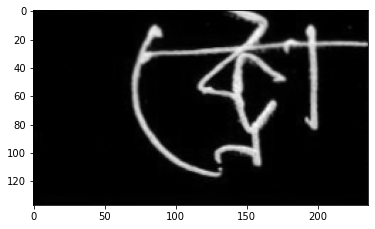

In [37]:
plt.imshow(img,cmap="gray")

pytorch model을 사용하기 위해서는 channel이라는 게 있어야 함. then, channel이 뭐임?

channel converting을 위해, 기존 $ n*m(배열) $행렬에 하나의 차원을 추가함.  쉽게 말해 배열인 m을 하나의 element 씩 배열화하여 다시 배열로 묶음.  

In [39]:
img = img[: , : , np.newaxis]
img.shape

(137, 236, 1)

### Pytorch에 모델에 넣을 수 있도록 변경

Pytorch 모델에 삽입을 위해서는

(B, W, H, C)  in Keras -> (B, C, W, H) in Pytorch
* B: Batch size
* W: Width
* H: Height
* C: Channel

In [43]:
from collections import OrderedDict

label_dict = OrderedDict()

for idx, column in enumerate(target_cols):
  label_dict[f"{column}"] = df_train.iloc[index][column]

In [49]:
class BangaliDataset(Dataset):
  # csv는 train.csv 파일을 로드한 dataframe
  # img_csv는 하나의 paquet으로 load한 dataframe
  def __init__(self,csv,img_csv,img_height,img_width):
    self.csv = csv.copy()

    self.img_ids = csv["image_id"]
    self.img_height = img_height
    self.img_width = img_width
    
    self.img_train_csv = img_csv
    self.img_train_id = self.img_train_csv["image_id"].reset_index()
    self.img_train = self.img_train_csv[self.img_train_csv.columns[1:]].values

  def __len__(self):
    return len(self.csv)

  def __getitem__(self, index):
    img_id = self.img_ids[index] # 결과값으로 얻어야하는 img_id => csv로 들어오는 값은 fold된 train값이라 idx와 가져오는 실 img_id가 다름
    # img 정보를 담은 데이터프레임에서 값을 들고와야 함
    img_train_index = (self.img_train_id["image_id"] == img_id) #parquet0의 image_id를 활용하여 parquet0의 image 넘파이 배열의 index값 추출
    img_train_index = self.img_train_id.loc[img_train_index].index #parquet0의 image_id를 활용하여 parquet0의 image 넘파이 배열의 index값 추출
    img = self.img_train[img_train_index].astype(np.uint8) #하나의 이미지를 추출
    img = img.reshape(self.img_height,self.img_width)
    img = 255 - img
    img = img[: , : , np.newaxis]

    label_1 = self.csv.loc[index].grapheme_root
    label_2 = self.csv.loc[index].vowel_diacritic
    label_3 = self.csv.loc[index].consonant_diacritic

    #torch.tensor: 우리가 channel을 만들어 input 데이터로 생성한 것을 torch.tensor형태로 변경
    #.permute: H,W,C의 순서를 각각 numbering으로 변경해주는 것

    return (torch.tensor(img, dtype=torch.float).permute(2,0,1),torch.tensor(label_1, dtype=torch.long), torch.tensor(label_2, dtype=torch.long), torch.tensor(label_3, dtype=torch.long))

In [ ]:
# df_train = pd.read_csv(path+"fold/parquet0_fold5.csv")

In [42]:
parquet0["image_id"] = parquet0["image_id"].apply(lambda x:int(x.split("_")[1]))
parquet0

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,50205,247,250,250,250,252,250,250,250,251,...,246,248,252,252,249,248,250,247,243,243
50206,50206,250,251,250,244,245,243,246,248,246,...,255,255,255,255,255,255,255,255,255,253
50207,50207,246,245,246,246,245,245,247,247,245,...,247,246,248,246,245,248,249,246,243,245
50208,50208,246,242,240,244,247,242,239,241,245,...,247,247,247,247,247,246,246,248,248,247


In [64]:
df_train.loc[np.logical_and(df_train.fold==2,df_train.image_id<50210)]

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,fold
9,9,64,7,1,তেঁ,2.0
15,15,72,2,2,র্দি,2.0
17,17,79,4,5,ধ্রু,2.0
46,46,139,2,2,র্ষি,2.0
50,50,151,1,2,র্স্থা,2.0
...,...,...,...,...,...,...
50190,50190,150,0,5,স্ত্র,2.0
50197,50197,117,7,0,ম্পে,2.0
50204,50204,115,0,0,ম,2.0
50206,50206,42,2,1,ছিঁ,2.0


In [46]:
valid_fold = 2 

X_valid = df_train.loc[df_train["fold"] == valid_fold]
X_train = df_train.loc[df_train["fold"] != valid_fold]

In [50]:
train_dataset = BangaliDataset(csv=X_train, img_csv=parquet0,img_height=img_height,img_width=img_width)

In [94]:
X_train.loc[X_train.image_id < 50210].image_id.nunique()

40167

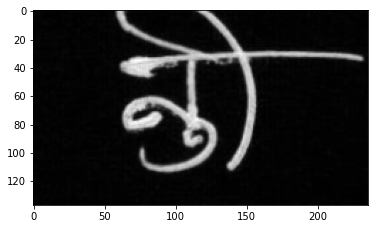

In [168]:
#target fold인 2fold를 제외한 parquet0의 나머지 0,1,3,4 폴드의 데이터에 대해서 만들어진 Tensor를 get하는 메소드
rand_value = np.random.randint(X_train.loc[X_train.image_id < 50210].image_id.count())

rand_value = X_train.loc[X_train.image_id < 50210].image_id.reset_index(drop=True).loc[rand_value]

plt.imshow( train_dataset[rand_value][0].permute(1,2,0).reshape(img_height,img_width),cmap="gray")

## 4. Make CNN model using pretrained models

<a href ="https://github.com/Cadene/pretrained-models.pytorch">pretrainedmodel package</a>

이미지 처리 대회를 할 때는, pretrained model이라는 패키지를 활용하며, 해당 패키지를 만든 저자의 페이지에서 모델별로 어떤 이미지 분류기가 좋은 성능을 보였는지 알 수 있다. 그러나, 진행함에 있어서 사용하기에 가벼운 모델부터 검증을 시작한다.

패키지의 장점 - 다양한 모델을 비슷한 사용 구조로 활용할 수 있다.

: pipeline은 그대로 두고 모델 이름만 바꾸기.

In [122]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 1.5 MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=80c86173ccb253c23f9f54e30f2c25cd743584cb306c05ff4c82091bf25a39e8
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [123]:
import pretrainedmodels

In [124]:
model_name = 'resnet34'
# 많은 사람들이 이미지 대회를 진행하며 얻어낸 유의미한 가중치 값을 가지고 사용할 수 있도록 imagenet의 결과 값을 받음 / 대회마다 pretrained weight를 사용할지 말지를 테스트해봐야 할 것임.
backbone = pretrainedmodels.__dict__[model_name](pretrained="imagenet") 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [125]:
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

imagenet으로 pretrained된 값은 channel값이 3이다. => R,G,B 색상을 반영하는 것이 Channel 값인듯하다.

(conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

따라서, 우리는 GrayScale의 이미지 값이기 때문에 이를 바꾸어야 한다.

1. covnet의 channel을 1로 바꾸어주던지
2. 우리의 grayscale 그림을 RGB값으로 할 수 있게끔 3 channel 화 
 하던지

In [127]:
train_dataset[rand_value][0].permute(1,2,0)

tensor([[[5.],
         [6.],
         [5.],
         ...,
         [2.],
         [2.],
         [2.]],

        [[3.],
         [3.],
         [3.],
         ...,
         [2.],
         [2.],
         [2.]],

        [[2.],
         [2.],
         [2.],
         ...,
         [0.],
         [1.],
         [1.]],

        ...,

        [[0.],
         [0.],
         [1.],
         ...,
         [2.],
         [3.],
         [3.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [2.],
         [4.],
         [3.]],

        [[2.],
         [2.],
         [2.],
         ...,
         [2.],
         [4.],
         [4.]]])

In [126]:
np.repeat(train_dataset[rand_value][0].permute(1,2,0).numpy(),3,2)

array([[[5., 5., 5.],
        [6., 6., 6.],
        [5., 5., 5.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        ...,
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        ...,
        [2., 2., 2.],
        [3., 3., 3.],
        [3., 3., 3.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [2., 2., 2.],
        [4., 4., 4.],
        [3., 3., 3.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        ...,
        [2., 2., 2.],
        [4., 4., 4.],
        [4., 4., 4.]]], dtype=float32)

3channel 이미지로 변경

In [128]:
np.repeat(train_dataset[10][0].permute(1,2,0).numpy(),3,2).shape

(137, 236, 3)

In [129]:
import torch.nn as nn

backbone.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [130]:
backbone.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)

In [131]:
backbone.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

* Warm up?

  학습을 시작하기 전에, imagenet으로 pretrained된 weight를 freeze시키고, 먼저 첫 번째 Conv만 실행해보기

* last_linear 조절

  해당 대회에서는 grapheme_root, vowel, consonant의 조합으로 인해 186개의 조합을 나타내는데, 이를 out_features에 반영해주어야 하기 때문이다. 그리고, 우리는 3개의 label을 가지고 결과를 나타내는데, last_linear로 모두 합쳐서 처리할 것인지, 각각 나눠서 처리할 것인지를 고려해야한다.

In [133]:
in_features = backbone.last_linear.in_features
in_features

512

In [134]:
backbone.last_linear = nn.Linear(in_features, 186)

In [135]:
backbone

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [136]:
batches = torch.rand(6,1,137,136)

In [137]:
batches.shape

torch.Size([6, 1, 137, 136])

In [139]:
outputs = backbone(batches)

In [140]:
outputs.shape

torch.Size([6, 186])

In [142]:
outputs.min()

tensor(-1.8608, grad_fn=<MinBackward1>)

## 5. Image Augmentation

In [171]:
train_dataset[rand_value][0].permute(1,2,0)

tensor([[[5.],
         [5.],
         [4.],
         ...,
         [3.],
         [5.],
         [5.]],

        [[5.],
         [3.],
         [2.],
         ...,
         [4.],
         [6.],
         [7.]],

        [[7.],
         [5.],
         [3.],
         ...,
         [2.],
         [5.],
         [5.]],

        ...,

        [[3.],
         [4.],
         [4.],
         ...,
         [2.],
         [4.],
         [5.]],

        [[3.],
         [3.],
         [3.],
         ...,
         [1.],
         [3.],
         [5.]],

        [[2.],
         [1.],
         [1.],
         ...,
         [1.],
         [2.],
         [2.]]])

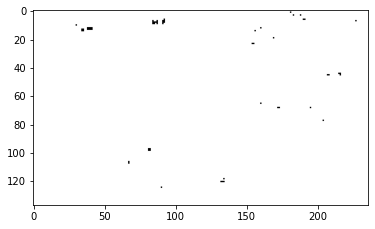

In [193]:
new_img= np.repeat(train_dataset[rand_value][0].permute(1,2,0).numpy().astype(np.uint8),3,2)
plt.imshow(new_img[:,:,],cmap=plt.cm.bone)

In [203]:
new_img[50,:,:]

tensor([[  2.,   2.,   2.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  3.,   3.,   3.],
        [  4.,   4.,   4.],
        [  4.,   4.,   4.],
        [  4.,   4.,   4.],
        [  3.,   3.,   3.],
        [  3.,   3.,   3.],
        [  2.,   2.,   2.],
        [  2.,   2.,   2.],
        [  4.,   4.,   4.],
        [  3.,   3.,   3.],
        [  2.,   2.,   2.],
        [  2.,   2.,   2.],
        [  3.,   3.,   3.],
        [  2.,   2.,   2.],
        [  2.,   2.,   2.],
        [  2.,   2.,   2.],
        [  3.,   3.,   3.],
        [  3.,   3.,   3.],
        [  4.,   4.,   4.],
        [  5.,   5.,   5.],
        [  4.,   4.,   4.],
        [  3.,   3.,   3.],
        [  3.,   3.,   3.],
        [  4.,   4.,   4.],
        [  4.,   4.,   4.],
        [  2.,   2.,   2.],
        [  2.,   2.,   2.],
        [  3.,   3.,   3.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  3.,   3.,

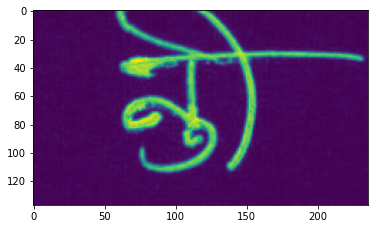

In [174]:
plt.imshow(train_dataset[rand_value][0].permute(1,2,0).reshape(img_height,img_width))

In [180]:
train_dataset[rand_value][0].permute(1,2,0).reshape(img_height,img_width).shape

torch.Size([137, 236])